In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm
import numpy as np
from numpy import linalg, mean, dot
from sklearn import tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


In [2]:
with open("../collect-data/src/files/nba_data.xlsx", "rb") as file:
    nba_stats_df = pd.read_excel(file, sheet_name="NBA Stats")
    mvp_df = pd.read_excel(file, sheet_name="MVP")

In [3]:
mvp_df["MVP?"] = 1
nba_stats_df["MVP?"] = 0

In [4]:
mvp_dict = mvp_df.to_dict("index")
nba_stats_dict = nba_stats_df.to_dict("index")
duplicate_mvps_dict = dict()
mvp_rank_dict = dict()

for k in mvp_dict:
    f_name = mvp_dict[k]["FIRST NAME"]
    l_name = mvp_dict[k]["LAST NAME"]
    team = mvp_dict[k]["TEAM"]
    season = mvp_dict[k]["SEASON"]
    # Filter down dataset
    for i in list(nba_stats_dict):
        if nba_stats_dict[i]["FIRST NAME"] == f_name and nba_stats_dict[i]["LAST NAME"] == l_name and nba_stats_dict[i]["TEAM"] == team and nba_stats_dict[i]["SEASON"] == season:
            nba_stats_dict[i]["MVP?"] = 1
            mvp_rank_dict[nba_stats_dict[i]["SEASON"]] = nba_stats_dict[i]["RANK"]
            duplicate_mvps_dict[i + 1000] = nba_stats_dict[i]
            duplicate_mvps_dict[i + 1001] = nba_stats_dict[i]
            duplicate_mvps_dict[i + 1002] = nba_stats_dict[i]
            duplicate_mvps_dict[i + 1003] = nba_stats_dict[i]

nba_stats_dict.update(duplicate_mvps_dict)

for season in mvp_rank_dict:
    rank = mvp_rank_dict[season]
    if rank > 15:
        max_rank = rank
    else:
        max_rank = 15
    for j in list(nba_stats_dict):
        if nba_stats_dict[j]["SEASON"] == season and nba_stats_dict[j]["RANK"] > max_rank:
            nba_stats_dict.pop(j)

nba_stats_df = pd.DataFrame.from_dict(nba_stats_dict, orient="index")
print(nba_stats_df["MVP?"].value_counts())


MVP?
0    1020
1     135
Name: count, dtype: int64


In [5]:

print(nba_stats_df[nba_stats_df["MVP?"] == "mvp"])

Empty DataFrame
Columns: [RANK, FIRST NAME, LAST NAME, SUFFIX, TEAM, AGE, GP, W, L, MIN, PTS, FGM, FGA, FG%, 3PM, 3PA, 3P%, FTM, FTA, FT%, OREB, DREB, REB, AST, TOV, STL, BLK, PF, FP, DD2, TD3, +/-, SEASON, MVP?]
Index: []

[0 rows x 34 columns]


In [6]:
model_df = nba_stats_df[['FIRST NAME', 'LAST NAME', 'SUFFIX', 'TEAM', 'AGE', 'SEASON', 'MVP?']]

In [7]:
nba_stats_df.head()

,RANK,FIRST NAME,LAST NAME,SUFFIX,TEAM,AGE,GP,W,L,MIN,...,TOV,STL,BLK,PF,FP,DD2,TD3,+/-,SEASON,MVP?
0,1,Luka,Doncic,NaN,DAL,25,70,46,24.0,2624.0,...,282,99,38,149,4304,49,21,319,2023-24,0
1,2,Shai,Gilgeous-Alexander,NaN,OKC,25,75,55,20.0,2552.7,...,162,150,67,184,3939,8,0,613,2023-24,0
2,3,Giannis,Antetokounmpo,NaN,MIL,29,73,45,28.0,2567.2,...,250,87,79,210,4193,57,10,339,2023-24,0
3,4,Jalen,Brunson,NaN,NYK,27,77,49,28.0,2726.3,...,186,70,13,144,3387,9,0,512,2023-24,0
4,5,Nikola,Jokic,NaN,DEN,29,79,55,24.0,2736.5,...,237,108,68,194,4609,68,25,682,2023-24,0


In [8]:
nba_stats_df = nba_stats_df.astype({"RANK": "object"})
nba_stats_df.dtypes

RANK           object
FIRST NAME     object
LAST NAME      object
SUFFIX         object
TEAM           object
AGE             int64
GP              int64
W               int64
L             float64
MIN           float64
PTS             int64
FGM             int64
FGA           float64
FG%           float64
3PM             int64
3PA           float64
3P%           float64
FTM             int64
FTA           float64
FT%           float64
OREB            int64
DREB            int64
REB             int64
AST             int64
TOV             int64
STL             int64
BLK             int64
PF              int64
FP              int64
DD2             int64
TD3             int64
+/-            object
SEASON         object
MVP?            int64
dtype: object

In [9]:
nba_stats_df["+/-"] = nba_stats_df["+/-"].apply(lambda x: int(x) if len(x) < 5 else 0)

In [10]:
# Bin the rankings together
nba_stats_df["RANK"] = pd.cut(nba_stats_df["RANK"], 15)
nba_stats_df["AGE"] = pd.cut(nba_stats_df["AGE"], 5)
nba_stats_df["+/-"] = pd.cut(nba_stats_df["+/-"], 10)
print(nba_stats_df)

                  RANK FIRST NAME           LAST NAME SUFFIX TEAM  \
0      (0.438, 38.467]       Luka              Doncic    NaN  DAL   
1      (0.438, 38.467]       Shai  Gilgeous-Alexander    NaN  OKC   
2      (0.438, 38.467]    Giannis       Antetokounmpo    NaN  MIL   
3      (0.438, 38.467]      Jalen             Brunson    NaN  NYK   
4      (0.438, 38.467]     Nikola               Jokic    NaN  DEN   
...                ...        ...                 ...    ...  ...   
13982  (0.438, 38.467]       Karl              Malone    NaN  UTA   
13539  (0.438, 38.467]    Michael              Jordan    NaN  CHI   
13540  (0.438, 38.467]    Michael              Jordan    NaN  CHI   
13541  (0.438, 38.467]    Michael              Jordan    NaN  CHI   
13542  (0.438, 38.467]    Michael              Jordan    NaN  CHI   

                AGE  GP   W     L     MIN  ...  TOV  STL  BLK   PF    FP  DD2  \
0      (17.2, 33.4]  70  46  24.0  2624.0  ...  282   99   38  149  4304   49   
1      (1

In [11]:
# rank_enc = pd.get_dummies(nba_stats_df["RANK"], dtype=float)
# nba_stats_df = pd.concat([nba_stats_df, rank_enc], axis=1)

# age_enc = pd.get_dummies(nba_stats_df["AGE"], dtype=float)
# nba_stats_df = pd.concat([nba_stats_df, age_enc], axis=1)

# plus_minus_enc = pd.get_dummies(nba_stats_df["+/-"], dtype=float)
# nba_stats_df = pd.concat([nba_stats_df, plus_minus_enc], axis=1)

# season_enc = pd.get_dummies(nba_stats_df["SEASON"], dtype=float)
# nba_stats_df = pd.concat([nba_stats_df, season_enc], axis=1)

# team_enc = pd.get_dummies(nba_stats_df["TEAM"], dtype=float)
# nba_stats_df = pd.concat([nba_stats_df, team_enc], axis=1)

print(nba_stats_df)


                  RANK FIRST NAME           LAST NAME SUFFIX TEAM  \
0      (0.438, 38.467]       Luka              Doncic    NaN  DAL   
1      (0.438, 38.467]       Shai  Gilgeous-Alexander    NaN  OKC   
2      (0.438, 38.467]    Giannis       Antetokounmpo    NaN  MIL   
3      (0.438, 38.467]      Jalen             Brunson    NaN  NYK   
4      (0.438, 38.467]     Nikola               Jokic    NaN  DEN   
...                ...        ...                 ...    ...  ...   
13982  (0.438, 38.467]       Karl              Malone    NaN  UTA   
13539  (0.438, 38.467]    Michael              Jordan    NaN  CHI   
13540  (0.438, 38.467]    Michael              Jordan    NaN  CHI   
13541  (0.438, 38.467]    Michael              Jordan    NaN  CHI   
13542  (0.438, 38.467]    Michael              Jordan    NaN  CHI   

                AGE  GP   W     L     MIN  ...  TOV  STL  BLK   PF    FP  DD2  \
0      (17.2, 33.4]  70  46  24.0  2624.0  ...  282   99   38  149  4304   49   
1      (1

In [12]:
current_season_df = nba_stats_df[nba_stats_df["SEASON"] == "2023-24"]
nba_stats_df = nba_stats_df[nba_stats_df["SEASON"] != "2023-24"]
print(current_season_df.shape)
print(nba_stats_df.shape)

(573, 34)
(582, 34)


In [13]:
# Change season to int
seasons_list = nba_stats_df["SEASON"].dropna().unique()
season_dict = { None: 1 }
for i in range(len(seasons_list)):
    season = seasons_list[i]
    season_dict[season] = i + 1

nba_stats_df = nba_stats_df.replace({ "SEASON": season_dict })

In [14]:
# nba_stats_df = nba_stats_df[['AGE', 'GP', 'W', 'L', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3PM', '3PA',
#        '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL',
#        'BLK', 'PF', 'FP', 'DD2', 'TD3', 'SEASON', 'MVP?']]
nba_stats_df = nba_stats_df.drop(columns=['RANK', 'MIN', 'PTS', 'FGM', 'FGA', 'AGE', 'FIRST NAME', 'LAST NAME', 'OREB', 'DREB',  'REB', 'SUFFIX', 'FP', 'TEAM', '+/-'], axis=1)
# nba_stats_df = nba_stats_df.drop(columns=['GP',   'W',   'L', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%',  'FTM',  'FTA',  'FT%', 'OREB', 'DREB',  'REB',  'AST',  'TOV', 'STL', 'BLK', 'PF', 'FP','DD2', 'TD3'], axis=1)
nba_stats_df.corr()

,GP,W,L,FG%,3PM,3PA,3P%,FTM,FTA,FT%,AST,TOV,STL,BLK,PF,DD2,TD3,SEASON,MVP?
GP,1.000000,0.480865,-0.496201,0.549216,0.223151,0.227141,-0.359926,0.320825,0.399376,-0.026050,0.321840,0.482444,0.379068,-0.120681,-0.421333,0.200312,-0.292498,0.321293,0.089679
W,0.480865,1.000000,-0.202932,0.394466,0.144447,0.115109,-0.132610,0.309632,0.343344,0.055988,0.330054,0.310032,0.238913,0.144531,-0.154107,0.304014,-0.202329,0.097405,0.517521
L,-0.496201,-0.202932,1.000000,-0.775433,-0.183031,-0.199001,0.897584,-0.135812,-0.377162,0.556213,-0.209744,-0.334016,-0.166242,0.397559,0.981209,-0.197188,0.706562,-0.250278,-0.104226
FG%,0.549216,0.394466,-0.775433,1.000000,-0.002785,-0.007499,-0.710164,0.225937,0.463570,-0.323836,0.185933,0.362880,0.084331,-0.065635,-0.722247,0.455219,-0.559917,0.184194,0.262037
3PM,0.223151,0.144447,-0.183031,-0.002785,1.000000,0.986214,0.090035,0.070140,-0.041625,0.249595,0.418283,0.288048,0.328379,-0.508082,-0.218756,-0.292625,-0.115123,-0.336964,0.021333
3PA,0.227141,0.115109,-0.199001,-0.007499,0.986214,1.000000,0.067903,0.120044,0.013228,0.225037,0.449616,0.338562,0.360520,-0.528464,-0.235235,-0.290432,-0.120531,-0.351941,0.007210
3P%,-0.359926,-0.132610,0.897584,-0.710164,0.090035,0.067903,1.000000,-0.108836,-0.404973,0.691919,-0.044118,-0.249720,-0.034494,0.191349,0.870574,-0.294072,0.663389,-0.330715,-0.095928
FTM,0.320825,0.309632,-0.135812,0.225937,0.070140,0.120044,-0.108836,1.000000,0.911642,0.113702,0.214334,0.558283,0.284370,0.092604,-0.094269,0.173584,-0.076201,0.021982,0.284389
FTA,0.399376,0.343344,-0.377162,0.463570,-0.041625,0.013228,-0.404973,0.911642,1.000000,-0.225582,0.184719,0.591612,0.248151,0.135000,-0.318313,0.323345,-0.245213,0.158884,0.290650
FT%,-0.026050,0.055988,0.556213,-0.323836,0.249595,0.225037,0.691919,0.113702,-0.225582,1.000000,0.099253,-0.038436,0.087554,-0.006547,0.533409,-0.257848,0.256840,-0.218210,-0.011862


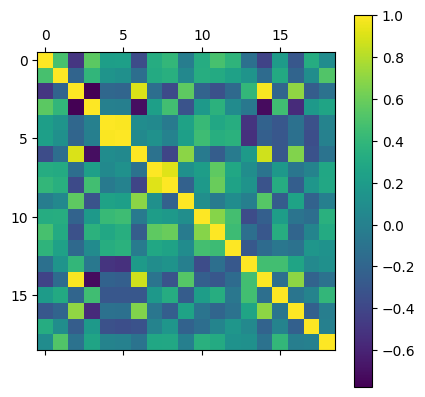

In [15]:
plt.matshow(nba_stats_df.corr())
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
plt.show()

In [16]:
len(nba_stats_df)

582

In [17]:
nba_stats_df.var()

GP          122.491001
W           155.580132
L         78522.592476
FG%          83.047691
3PM        7029.364578
3PA       44529.329866
3P%         744.353496
FTM       17816.814761
FTA       32327.122685
FT%         167.748311
AST       32140.745734
TOV        3737.232018
STL        1385.393311
BLK        3331.128440
PF        61234.633249
DD2         397.180418
TD3        1094.753908
SEASON       60.625740
MVP?          0.178461
dtype: float64

In [18]:
nba_stats_df.cov()

,GP,W,L,FG%,3PM,3PA,3P%,FTM,FTA,FT%,AST,TOV,STL,BLK,PF,DD2,TD3,SEASON,MVP?
GP,122.491001,66.382242,-1538.889012,55.393563,207.065901,530.481615,-108.681420,473.953298,794.725419,-3.734095,638.586452,326.417842,156.154876,-77.087868,-1153.920116,44.182829,-107.110953,27.687380,0.419291
W,66.382242,155.580132,-709.290850,44.838435,151.057570,302.975642,-45.127642,515.511782,769.998256,9.044858,738.056657,236.406063,110.918475,104.048024,-475.661302,75.572733,-83.501517,9.459952,2.726946
L,-1538.889012,-709.290850,78522.592476,-1980.183796,-4300.102787,-11767.280821,6862.177360,-5079.845882,-19002.413096,2018.681889,-10536.942141,-5721.893753,-1733.898618,6429.763182,68038.934131,-1101.216416,6550.969585,-546.070951,-12.337975
FG%,55.393563,44.838435,-1980.183796,83.047691,-2.128213,-14.421083,-176.567977,274.830852,759.560708,-38.222420,303.772358,202.163246,28.604736,-34.521763,-1628.725379,82.675775,-168.828398,13.069758,1.008783
3PM,207.065901,151.057570,-4300.102787,-2.128213,7029.364578,17448.268920,205.947660,784.940549,-627.476759,271.033551,6287.190553,1476.377761,1024.754680,-2458.598266,-4538.540891,-488.948533,-319.359441,-219.973215,0.755585
3PA,530.481615,302.975642,-11767.280821,-14.421083,17448.268920,44529.329866,390.932698,3381.252889,501.889227,615.043344,17009.550571,4367.534692,2831.643848,-6436.269834,-12283.552686,-1221.409605,-841.550453,-578.257890,0.642702
3P%,-108.681420,-45.127642,6862.177360,-176.567977,205.947660,390.932698,744.353496,-396.349101,-1986.546610,244.497081,-215.789836,-416.503552,-35.028048,301.308283,5877.513427,-159.895617,598.847180,-70.254059,-1.105621
FTM,473.953298,515.511782,-5079.845882,274.830852,784.940549,3381.252889,-396.349101,17816.814761,21878.768863,196.567263,5129.020885,4555.587673,1412.813093,713.411741,-3113.732828,461.763694,-336.536153,22.846275,16.036118
FTA,794.725419,769.998256,-19002.413096,759.560708,-627.476759,501.889227,-1986.546610,21878.768863,32327.122685,-525.312607,5954.196268,6502.729756,1660.683417,1400.916344,-14162.377912,1158.628487,-1458.764952,222.428920,22.076228
FT%,-3.734095,9.044858,2018.681889,-38.222420,271.033551,615.043344,244.497081,196.567263,-525.312607,167.748311,230.461978,-30.433021,42.207741,-4.893989,1709.573600,-66.555880,110.065027,-22.005585,-0.064903


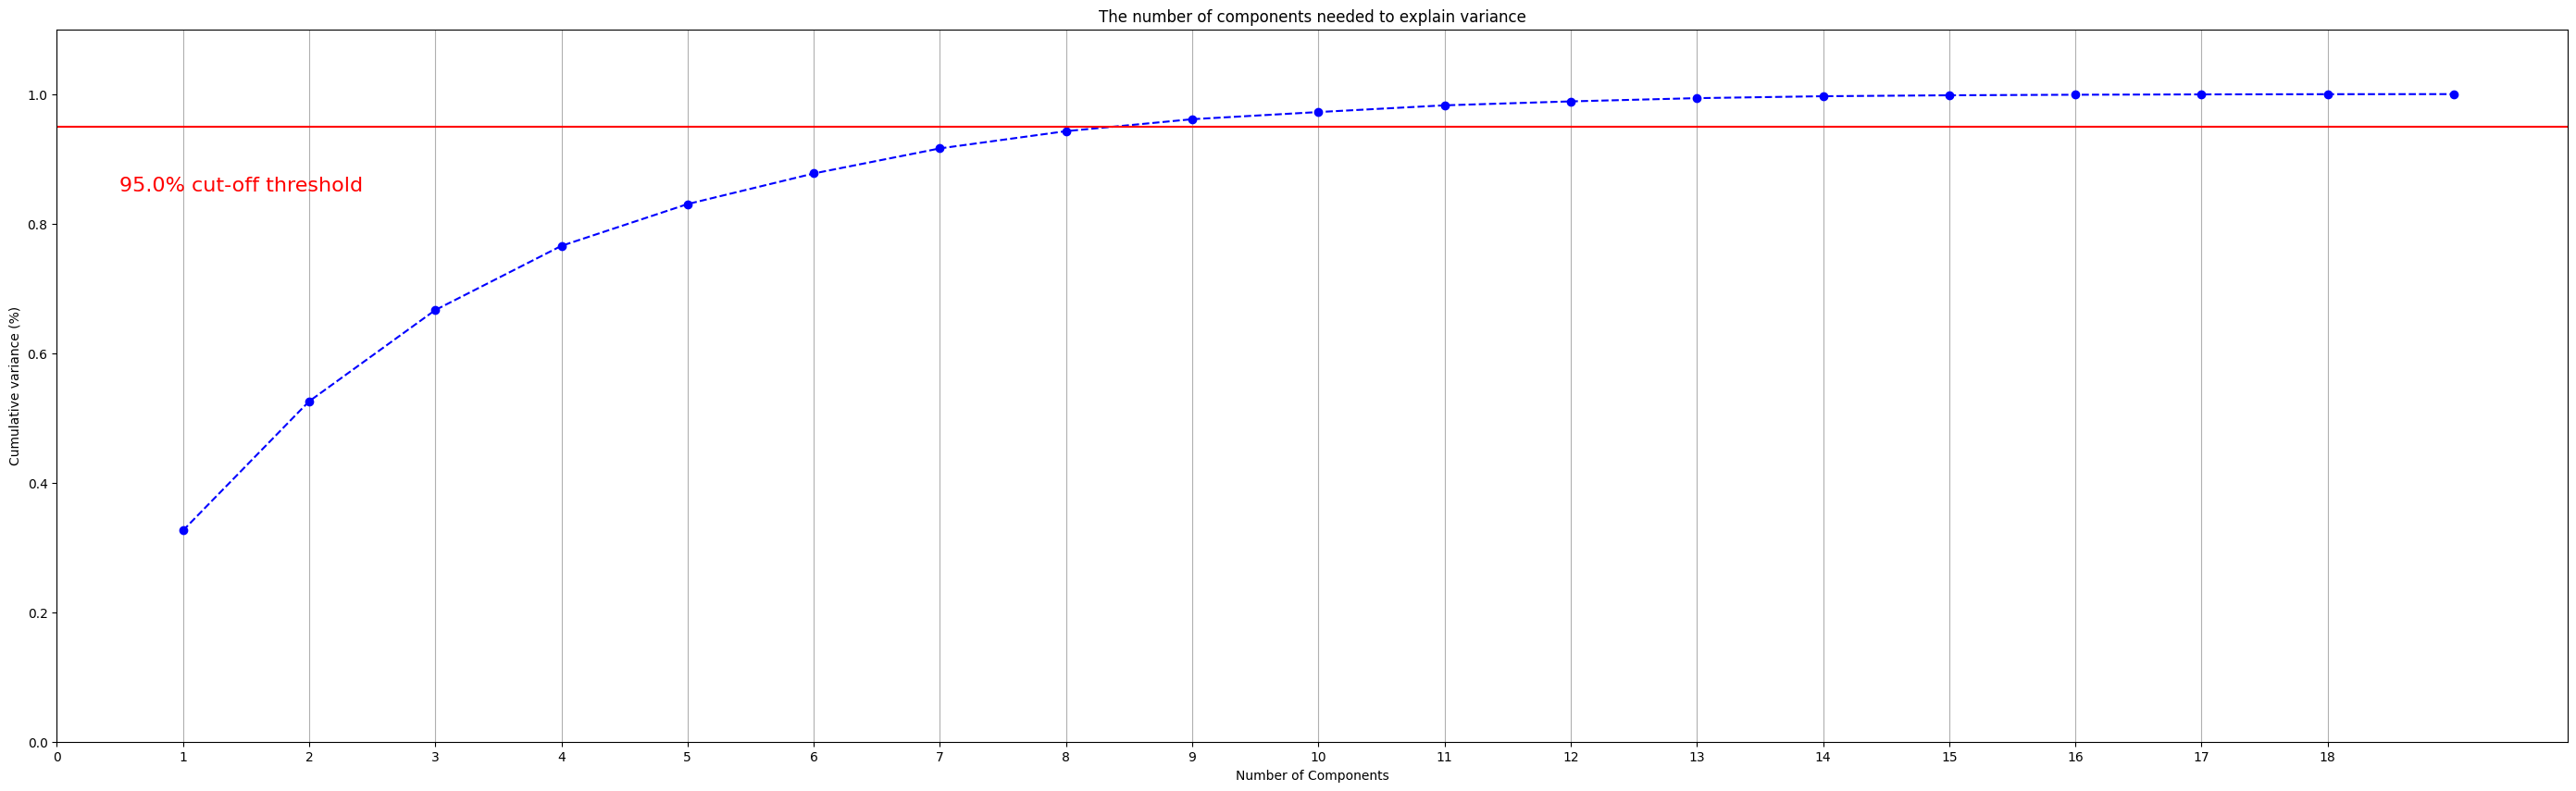

array([[-1.90455468e+02,  3.15168658e+02, -6.39585693e+01, ...,
         9.95720562e-02,  5.28305438e-01,  3.39379317e-01],
       [-8.42481975e+01, -1.36991133e+02, -3.37081796e+02, ...,
        -2.62662239e+00,  2.36798283e+00, -5.56835614e-01],
       [-1.94806107e+02,  2.78767730e+02, -1.65262884e+02, ...,
        -7.32096309e-01,  7.69781541e-01,  2.19085992e-01],
       ...,
       [-8.93712564e+01, -2.05935507e+02, -2.39746453e+02, ...,
         1.34713965e+00, -1.73637487e-01, -6.00151641e-01],
       [-8.93712564e+01, -2.05935507e+02, -2.39746453e+02, ...,
         1.34713965e+00, -1.73637487e-01, -6.00151641e-01],
       [-8.93712564e+01, -2.05935507e+02, -2.39746453e+02, ...,
         1.34713965e+00, -1.73637487e-01, -6.00151641e-01]])

In [19]:
def generate_pc(columns, variance_pct):
    scaler = MinMaxScaler()
    data_rescaled = scaler.fit_transform(columns.to_numpy())

    pca = PCA().fit(data_rescaled)
    plt.rcParams["figure.figsize"] = (35,10)

    fig, ax = plt.subplots()
    xi = np.arange(1, 20, step=1)
    y = np.cumsum(pca.explained_variance_ratio_)

    plt.ylim(0.0,1.1)
    plt.plot(xi, y, marker="o", linestyle="--", color="b")

    plt.xlabel("Number of Components")
    plt.xticks(np.arange(0, 19, step=1))
    plt.ylabel("Cumulative variance (%)")
    plt.title("The number of components needed to explain variance")

    plt.axhline(y=variance_pct, color="r", linestyle="-")
    plt.text(0.5, 0.85, f"{variance_pct * 100}% cut-off threshold", color="red", fontsize=16)

    ax.grid(axis="x")
    plt.show()
    return pca
pca = generate_pc(nba_stats_df, 0.95)

pca.fit(nba_stats_df.to_numpy())
pca.transform(nba_stats_df.to_numpy())

In [20]:
# projected.plot(kind="scatter", x="pc1", y="pc2")
nba_stats_df.columns

Index(['GP', 'W', 'L', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'AST',
       'TOV', 'STL', 'BLK', 'PF', 'DD2', 'TD3', 'SEASON', 'MVP?'],
      dtype='object')

In [21]:
# Decision Tree
Y = nba_stats_df["MVP?"]
X = nba_stats_df.drop("MVP?", axis=1)
X.columns = X.columns.astype(str)
max_depths = [2,3,4,5,6,7,8,9,10]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.8, random_state=1)
for depth in max_depths:
    clf = tree.DecisionTreeClassifier(max_depth=depth)
    clf = clf.fit(X_train, Y_train)
    Y_predtest = clf.predict(X_test)
    Y_predtrain = clf.predict(X_train)
    print("depth:", depth, "test accuracy:", accuracy_score(Y_test, Y_predtest), "train accuracy:", accuracy_score(Y_train, Y_predtrain))
    print(pd.crosstab(Y_test, Y_predtest, rownames = ['Actual'], colnames =['Predicted'], margins = True))

depth: 2 test accuracy: 0.8540772532188842 train accuracy: 0.8879310344827587
Predicted    0    1  All
Actual                  
0          302   55  357
1           13   96  109
All        315  151  466
depth: 3 test accuracy: 0.8733905579399142 train accuracy: 0.9224137931034483
Predicted    0    1  All
Actual                  
0          318   39  357
1           20   89  109
All        338  128  466
depth: 4 test accuracy: 0.8540772532188842 train accuracy: 0.9655172413793104
Predicted    0    1  All
Actual                  
0          313   44  357
1           24   85  109
All        337  129  466
depth: 5 test accuracy: 0.8948497854077253 train accuracy: 0.9913793103448276
Predicted    0    1  All
Actual                  
0          318   39  357
1           10   99  109
All        328  138  466
depth: 6 test accuracy: 0.8583690987124464 train accuracy: 0.9913793103448276
Predicted    0    1  All
Actual                  
0          320   37  357
1           29   80  109
All       

In [22]:
print(classification_report(Y_test, Y_predtest, zero_division=0))

              precision    recall  f1-score   support

           0       0.96      0.91      0.93       357
           1       0.74      0.86      0.80       109

    accuracy                           0.90       466
   macro avg       0.85      0.88      0.86       466
weighted avg       0.91      0.90      0.90       466



In [23]:
pd.crosstab(Y_test, Y_predtest, rownames = ['Actual'], colnames =['Predicted'], margins = True)

Predicted,0,1,All
Actual,,,
0,324,33,357
1,15,94,109
All,339,127,466


In [24]:
# Predict mvp per season
seasons = nba_stats_df["SEASON"].unique()

for season in seasons:
    print(seasons_list[season - 1])
    season_stats_df = nba_stats_df[nba_stats_df["SEASON"] == season]
    Y = season_stats_df["MVP?"]
    X = season_stats_df.drop("MVP?", axis=1)
    X.columns = X.columns.astype(str)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.8, random_state=43)
    clf = tree.DecisionTreeClassifier(max_depth=8)
    clf = clf.fit(X_train, Y_train)
    Y_predtest = clf.predict(X_test)
    Y_predtrain = clf.predict(X_train)
    print("depth:", depth, "test accuracy:", accuracy_score(Y_test, Y_predtest), "train accuracy:", accuracy_score(Y_train, Y_predtrain))
    print(pd.crosstab(Y_test, Y_predtest, rownames = ['Actual'], colnames =['Predicted'], margins = True))
    print("\n")

2022-23
depth: 10 test accuracy: 0.9655172413793104 train accuracy: 1.0
Predicted   0  1  All
Actual               
0          25  1   26
1           0  3    3
All        25  4   29


2021-22
depth: 10 test accuracy: 0.9375 train accuracy: 1.0
Predicted   0  1  All
Actual               
0          12  1   13
1           0  3    3
All        12  4   16


2020-21
depth: 10 test accuracy: 0.9375 train accuracy: 1.0
Predicted   0  1  All
Actual               
0          11  1   12
1           0  4    4
All        11  5   16


2019-20
depth: 10 test accuracy: 0.9375 train accuracy: 1.0
Predicted   0  1  All
Actual               
0          11  1   12
1           0  4    4
All        11  5   16


2018-19
depth: 10 test accuracy: 0.8125 train accuracy: 1.0
Predicted  0  1  All
Actual              
0          9  3   12
1          0  4    4
All        9  7   16


2017-18
depth: 10 test accuracy: 0.9375 train accuracy: 1.0
Predicted   0  1  All
Actual               
0          11  1   12
1      

In [25]:
model_df = pd.concat([model_df, nba_stats_df], axis=1)
model_df.to_excel("./processed_files/nba_model_data.xlsx", sheet_name="NBA Stats Edited")

In [26]:
# Results after applying PCA
# for season in seasons:
#     print(seasons_list[season - 1])
#     season_stats_df = nba_stats_df[nba_stats_df["SEASON"] == season]
#     Y = season_stats_df["MVP?"]
#     X = season_stats_df.drop("MVP?", axis=1)
#     X.columns = X.columns.astype(str)
#     X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.8, random_state=43)
#     pca.fit(X_train)
#     explained_variance = pca.explained_variance_ratio_
#     cum_explained_ratio = np.cumsum(explained_variance)
#     optimal_num_comp = np.where(cum_explained_ratio >= 0.95)[0][0] + 1

#     pca = PCA(n_components=optimal_num_comp, svd_solver="full")
#     X_train_pca = pca.fit_transform(X_train)
#     X_test_pca = pca.transform(X_test)

#     pca_tree = tree.DecisionTreeClassifier(random_state=42)
#     pca_tree = pca_tree.fit(X_train_pca, Y_train)

#     Y_pred = pca_tree.predict(X_test_pca)
#     print(accuracy_score(Y_test, Y_pred))
#     print(pd.crosstab(Y_test, Y_pred, rownames = ['Actual'], colnames =['Predicted'], margins = True))

In [27]:
print(classification_report(Y_test, Y_pred, zero_division=0))

NameError: name 'Y_pred' is not defined

In [ ]:
pd.crosstab(Y_test, Y_pred, rownames = ['Actual'], colnames =['Predicted'], margins = True)